In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df = pd.read_csv('VCB.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,6/1/2018,43216,41017,43595,40866,7.57M,5.36%
1,6/4/2018,44960,42837,45187,42458,4.90M,4.04%
2,6/5/2018,44429,44429,45187,43747,4.51M,-1.18%
3,6/6/2018,44808,44050,45263,43671,2.79M,0.85%
4,6/7/2018,44505,44732,44960,44278,3.24M,-0.68%


In [ ]:
# Take AR Model of lag = 3, 2 differencing for stationary
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df['Price'].iloc[:train_size]
test_data =  df['Price'].iloc[train_size:]

In [ ]:
from pmdarima.arima import auto_arima
best_arima = auto_arima(train_data,trace=True)
best_arima.fit(train_data)
print(best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14610.829, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14607.896, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14609.602, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14609.612, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14606.892, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14611.582, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.325 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  869
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7302.446
Date:                Fri, 16 Jun 2023   AIC                          14606.892
Time:                        22:06:42   BIC                          14611.658
Sample:                             0   HQIC                         14608.716
    

In [ ]:
# summary of fit model
arimax_train = df[['Price','Low']].iloc[:train_size]
arimax_test = df[['Price','Low']].iloc[train_size:]
arimax_model = ARIMA(arimax_train['Price'],exog=arimax_train['Low'],order=(0,1,0))
arimax_fitted = arimax_model.fit()
print(arimax_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  869
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -7187.469
Date:                Fri, 16 Jun 2023   AIC                          14378.937
Time:                        22:06:44   BIC                          14388.469
Sample:                             0   HQIC                         14382.585
                                - 869                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Low            0.4785      0.019     25.144      0.000       0.441       0.516
sigma2      9.117e+05   2.84e+04     32.147      0.000    8.56e+05    9.67e+05
Ljung-Box (L1) (Q):                 131.94   Jarque-

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_arimax= arimax_fitted.predict(start=len(df)-test_size,end=len(df)-1,exog= arimax_test['Low'])

# 5. Quá trình Validate
x_val= np.array(df['Price'].index).reshape(-1, 1)
y_val = np.array(df['Price'])
y_pred_val_arimax =  arimax_fitted.predict(start=0,end=train_size-1,exog=arimax_train['Low'])
y_pred_val_arimax = pd.concat([y_pred_val_arimax,y_pred_arimax])

ARIMAX Validation RMSE: 3100.855805738614
ARIMAX Testing RMSE: 5328.588552713571
Validation MAPE: 2.3083817071287482
Testing MAPE: 4.941144521433235
Validation MAE: 1766.2195277175429
Testing MAE: 4236.140173194026


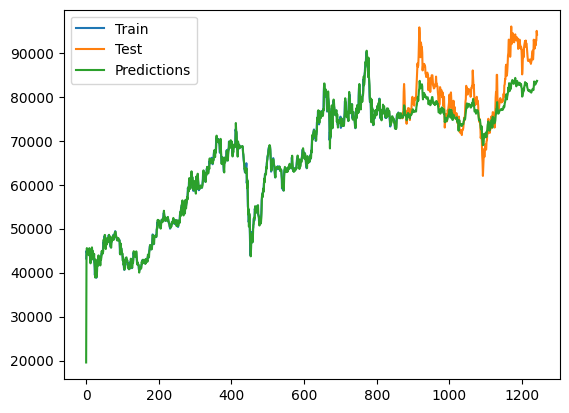

In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val_arimax - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_arimax - y_test)**2))
print('ARIMAX Validation RMSE:', valid_rmse)
print('ARIMAX Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val_arimax - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred_arimax - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val_arimax - y_val))
test_mae = np.mean(np.abs(y_pred_arimax - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(df['Price'].index, y_pred_val_arimax)
# plt.plot(last_data,y_next_10_arima)
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()